In [20]:
!pip install flask flask-ngrok

In [21]:
!pip install pyngrok

In [23]:
from pyngrok import ngrok  # ngrok을 사용하려면 이 라이브러리가 필요합니다.
!ngrok authtoken '2rhzQyM0RtDG5QRxYF7a84U86HY_2VBGDtxj5CAZYjQXuSgdu'  # ngrok 인증 토큰 설정

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [67]:
from flask import Flask, render_template, request
import pandas as pd
import numpy as np
import json
import requests
import io

# 카카오 API 키
KAKAO_API_KEY = "695ff44e2f92442949444abdd8ef53ee"

# 하버사인 거리 함수
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371000  # 지구 반지름 (미터)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    delta_phi = lat2 - lat1
    delta_lambda = lon2 - lon1

    a = np.sin(delta_phi / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# 카카오 API를 사용해 주소 -> 좌표 변환
def get_location(address):
    url = f'https://dapi.kakao.com/v2/local/search/address.json?query={address}'
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    response = requests.get(url, headers=headers)
    api_json = json.loads(response.text)
    if not api_json['documents']:
        raise ValueError("주소를 찾을 수 없습니다.")

    address_info = api_json['documents'][0]['address']
    crd = {"lat": float(address_info['y']), "lng": float(address_info['x'])}
    return crd

# 총 점수 계산 함수
def calculate_total_score(cctv_count, lamp_count, bus_stop_count, school_count):
    return cctv_count + lamp_count + bus_stop_count + school_count

# 500m 내 요소 계산 함수
def calculate_proximity(address, cctv_data, lamp_data, bus_data, school_data):
    try:
        # 주소 -> 좌표 변환
        coordinates = get_location(address)
        center_lat, center_lon = coordinates['lat'], coordinates['lng']

        # CCTV 계산
        cctv_distances = haversine_np(
            np.full(cctv_data.shape[0], center_lat),
            np.full(cctv_data.shape[0], center_lon),
            cctv_data['WGS84위도'].to_numpy(),
            cctv_data['WGS84경도'].to_numpy()
        )
        cctv_camera_sum = cctv_data.loc[cctv_distances <= 500, '카메라대수'].sum()

        # 가로등 계산
        lamp_distances = haversine_np(
            np.full(lamp_data.shape[0], center_lat),
            np.full(lamp_data.shape[0], center_lon),
            lamp_data['위도'].to_numpy(),
            lamp_data['경도'].to_numpy()
        )
        lamp_count = np.sum(lamp_distances <= 500)

        # 버스 정류장 계산
        bus_distances = haversine_np(
            np.full(bus_data.shape[0], center_lat),
            np.full(bus_data.shape[0], center_lon),
            bus_data['위도'].to_numpy(),
            bus_data['경도'].to_numpy()
        )
        bus_stop_count = np.sum(bus_distances <= 500)

        # 학교 계산
        school_distances = haversine_np(
            np.full(school_data.shape[0], center_lat),
            np.full(school_data.shape[0], center_lon),
            school_data['위도'].to_numpy(),
            school_data['경도'].to_numpy()
        )
        school_count = np.sum(school_distances <= 500)

        # 총 점수 계산
        total_score = calculate_total_score(cctv_camera_sum, lamp_count, bus_stop_count, school_count)

        # 결과 반환
        return {
            "address": address,
            "cctv_count": cctv_camera_sum,
            "lamp_count": lamp_count,
            "bus_stop_count": bus_stop_count,
            "school_count": school_count,
            "total_score": total_score
        }

    except ValueError as e:
        return {"error": str(e)}

# 피클 파일 로드
def load_pickle_data(url):
    response = requests.get(url)
    response.raise_for_status()  # 요청 실패 시 에러 표시
    return pd.read_pickle(io.BytesIO(response.content))

# 데이터 URL
bus_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/bus_data.pkl"
cctv_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/cctv_data.pkl"
lamp_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/lamp_data.pkl"
school_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/school_data.pkl"

# 피클 파일 로딩
bus_data = load_pickle_data(bus_url)
cctv_data = load_pickle_data(cctv_url)
lamp_data = load_pickle_data(lamp_url)
school_data = load_pickle_data(school_url)

In [68]:
app = Flask(__name__)

# Flask 서버를 ngrok으로 연결
public_url = ngrok.connect(5000)
print(" * ngrok tunnel \"{}\" -> http://127.0.0.1:5000".format(public_url))

app.template_folder = '/content/templates'

@app.route("/", methods=["GET", "POST"])
def index():
    result = None
    if request.method == "POST":
        address = request.form["address"]
        result = calculate_proximity(address, cctv_data, lamp_data, bus_data, school_data)
    return render_template("formm.html", result=result)

if __name__ == "__main__":
    app.run(debug=False)


 * ngrok tunnel "NgrokTunnel: "https://3628-34-29-12-149.ngrok-free.app" -> "http://localhost:5000"" -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 13:08:41] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 13:08:49] "POST / HTTP/1.1" 200 -


#그래프 추가 ver.

 * ngrok tunnel "NgrokTunnel: "https://1023-34-29-12-149.ngrok-free.app" -> "http://localhost:5000"" -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 13:11:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 13:11:51] "POST / HTTP/1.1" 200 -


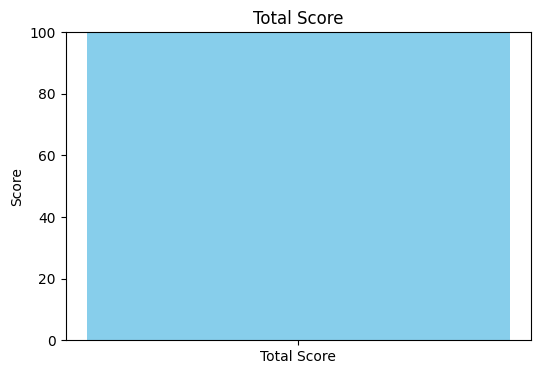

In [70]:
import matplotlib.pyplot as plt
import io
import base64
from flask import Flask, render_template, request, send_file
import pandas as pd
import requests
import json
import numpy as np
import io
from io import BytesIO

# 카카오 API 키
KAKAO_API_KEY = "695ff44e2f92442949444abdd8ef53ee"

# 주소 -> 좌표 변환
def get_location(address):
    url = f'https://dapi.kakao.com/v2/local/search/address.json?query={address}'
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    response = requests.get(url, headers=headers)
    api_json = json.loads(response.text)
    if not api_json['documents']:
        raise ValueError("주소를 찾을 수 없습니다.")

    address_info = api_json['documents'][0]['address']
    crd = {"lat": float(address_info['y']), "lng": float(address_info['x'])}
    return crd

# 좌표 -> 주소 변환
def get_address(lat, lng):
    url = f"https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x={lng}&y={lat}"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    api_json = requests.get(url, headers=headers)
    full_address = json.loads(api_json.text)
    return full_address['documents'][0]

# 반경 500m 내 요소 계산 함수
def calculate_proximity(lat, lng, cctv_data, lamp_data, bus_data, school_data):
    # CCTV 계산
    cctv_distances = haversine_np(
        np.full(cctv_data.shape[0], lat),
        np.full(cctv_data.shape[0], lng),
        cctv_data['WGS84위도'].to_numpy(),
        cctv_data['WGS84경도'].to_numpy()
    )
    cctv_camera_sum = cctv_data.loc[cctv_distances <= 500, '카메라대수'].sum()

    # 가로등 계산
    lamp_distances = haversine_np(
        np.full(lamp_data.shape[0], lat),
        np.full(lamp_data.shape[0], lng),
        lamp_data['위도'].to_numpy(),
        lamp_data['경도'].to_numpy()
    )
    lamp_count = np.sum(lamp_distances <= 500)

    # 버스 정류장 계산
    bus_distances = haversine_np(
        np.full(bus_data.shape[0], lat),
        np.full(bus_data.shape[0], lng),
        bus_data['위도'].to_numpy(),
        bus_data['경도'].to_numpy()
    )
    bus_stop_count = np.sum(bus_distances <= 500)

    # 학교 계산
    school_distances = haversine_np(
        np.full(school_data.shape[0], lat),
        np.full(school_data.shape[0], lng),
        school_data['위도'].to_numpy(),
        school_data['경도'].to_numpy()
    )
    school_count = np.sum(school_distances <= 500)

    # 총 점수 계산
    total_score = 0.25*cctv_camera_sum + 0.25*lamp_count + 0.25*bus_stop_count + 0.25*school_count
    return total_score

# y 값 계산 함수 (가중치 1)
def calculate_y(total):
    #y = (total / total.max()) * 100  # y 값을 0 ~ 100 사이로 스케일링
    y = (total/1000)*100
    return y

# 클러스터 값에 따른 y 값 조정 함수
def adjust_y_for_cluster(y, cluster_value):
    if cluster_value == 1:
        y = y * 0.7  # 클러스터 값이 1일 경우 y 값에 0.7 곱하기
    return y

# 피클 파일 로딩 함수
def load_pickle_data(url):
    response = requests.get(url)
    response.raise_for_status()  # 요청 실패 시 에러 표시
    return pd.read_pickle(io.BytesIO(response.content))

# 데이터 로드
clustering_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/clustering_data.pkl"
bus_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/bus_data.pkl"
cctv_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/cctv_data.pkl"
lamp_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/lamp_data.pkl"
school_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/school_data.pkl"

# 피클 파일 로딩
bus_data = load_pickle_data(bus_url)
cctv_data = load_pickle_data(cctv_url)
lamp_data = load_pickle_data(lamp_url)
school_data = load_pickle_data(school_url)
clustering_data = load_pickle_data(clustering_url)

# 주소를 위도, 경도로 변환하고, 반경 500m 내 요소 계산 후 y 값 계산
def process_address(address, cctv_data, lamp_data, bus_data, school_data):
    # 주소를 위도, 경도로 변환
    coord_info = get_location(address)
    lat = float(coord_info['lat'])
    lng = float(coord_info['lng'])

    # 500m 내 요소 계산
    total_score = calculate_proximity(lat, lng, cctv_data, lamp_data, bus_data, school_data)

    # X_scaled 데이터와 가중치(weights)가 주어졌을 때 y 값 계산
    y = calculate_y(total_score)

    # 동으로 변환
    address_info = get_address(lat, lng)
    region_code = int(address_info['code'])

    # 클러스터 값에 따라 y 값 조정
    cluster_value = clustering_data[clustering_data['법정동코드'] == region_code]['cluster'].values[0]
    y_adjusted = adjust_y_for_cluster(y, cluster_value)

    return total_score, y_adjusted, region_code

# 그래프 생성 함수
def create_bar_chart(total_score):
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(['Total Score'], [total_score], color='skyblue')
    ax.set_ylim(0, 100)  # y축 범위 설정
    ax.set_ylabel('Score')
    ax.set_title('Total Score')

    # 그래프를 이미지로 저장
    img = BytesIO()
    fig.savefig(img, format='png')
    img.seek(0)

    # 이미지 데이터를 base64로 변환
    img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
    return img_base64



app = Flask(__name__)

# Flask 서버를 ngrok으로 연결
public_url = ngrok.connect(5000)
print(" * ngrok tunnel \"{}\" -> http://127.0.0.1:5000".format(public_url))

app.template_folder = '/content/templates'


@app.route("/", methods=["GET", "POST"])
def index():
    result = None
    if request.method == "POST":
        address = request.form["address"]
        total_score, y_adjusted, region_code = process_address(address, cctv_data, lamp_data, bus_data, school_data)

        # 그래프 이미지 생성
        bar_chart_img = create_bar_chart(total_score)

        result = {
            "total_score": total_score,
            "y_adjusted": y_adjusted,
            "region_code": region_code,
            "bar_chart_img": bar_chart_img
        }

    return render_template("test.html", result=result)


if __name__ == "__main__":
    app.run(debug=False)

##지도 추가 ver.

 * ngrok tunnel "NgrokTunnel: "https://e698-34-29-12-149.ngrok-free.app" -> "http://localhost:5000"" -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 14:01:53] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Jan/2025 14:01:58] "POST / HTTP/1.1" 200 -


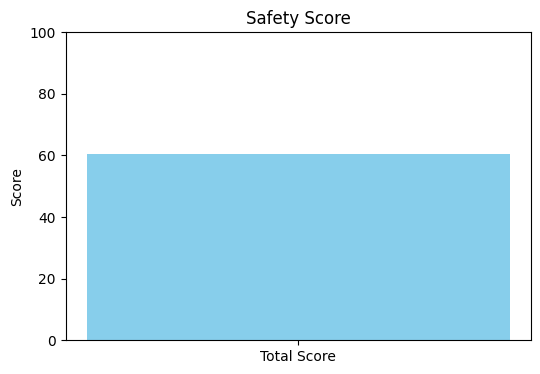

In [84]:
import matplotlib.pyplot as plt
import io
import base64
from flask import Flask, render_template, request
import pandas as pd
import requests
import json
import numpy as np
import io
from io import BytesIO

# 카카오 API 키
KAKAO_API_KEY = "695ff44e2f92442949444abdd8ef53ee"

# 주소 -> 좌표 변환
def get_location(address):
    url = f'https://dapi.kakao.com/v2/local/search/address.json?query={address}'
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    response = requests.get(url, headers=headers)
    api_json = json.loads(response.text)
    if not api_json['documents']:
        raise ValueError("주소를 찾을 수 없습니다.")

    address_info = api_json['documents'][0]['address']
    crd = {"lat": float(address_info['y']), "lng": float(address_info['x'])}
    return crd

# 좌표 -> 주소 변환
def get_address(lat, lng):
    url = f"https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x={lng}&y={lat}"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    api_json = requests.get(url, headers=headers)
    full_address = json.loads(api_json.text)
    return full_address['documents'][0]

# 반경 500m 내 요소 계산 함수
def calculate_proximity(lat, lng, cctv_data, lamp_data, bus_data, school_data):
    # CCTV 계산
    cctv_distances = haversine_np(
        np.full(cctv_data.shape[0], lat),
        np.full(cctv_data.shape[0], lng),
        cctv_data['WGS84위도'].to_numpy(),
        cctv_data['WGS84경도'].to_numpy()
    )
    cctv_camera_sum = cctv_data.loc[cctv_distances <= 500, '카메라대수'].sum()

    # 가로등 계산
    lamp_distances = haversine_np(
        np.full(lamp_data.shape[0], lat),
        np.full(lamp_data.shape[0], lng),
        lamp_data['위도'].to_numpy(),
        lamp_data['경도'].to_numpy()
    )
    lamp_count = np.sum(lamp_distances <= 500)

    # 버스 정류장 계산
    bus_distances = haversine_np(
        np.full(bus_data.shape[0], lat),
        np.full(bus_data.shape[0], lng),
        bus_data['위도'].to_numpy(),
        bus_data['경도'].to_numpy()
    )
    bus_stop_count = np.sum(bus_distances <= 500)

    # 학교 계산
    school_distances = haversine_np(
        np.full(school_data.shape[0], lat),
        np.full(school_data.shape[0], lng),
        school_data['위도'].to_numpy(),
        school_data['경도'].to_numpy()
    )
    school_count = np.sum(school_distances <= 500)

    # 총 점수 계산
    total_score = 0.25*cctv_camera_sum + 0.25*lamp_count + 0.25*bus_stop_count + 0.25*school_count
    return total_score

# y 값 계산 함수
def calculate_y(total):
    min_z = -3
    max_z = 3
    z = ( (total-282.48)/121.75 )
    y = ((z - min_z) / (max_z - min_z)) * 50 + 50
    return y

# 클러스터 값에 따른 y 값 조정 함수
def adjust_y_for_cluster(y, cluster_value):
    if cluster_value == 1:
        y = y * 0.7  # 클러스터 값이 1일 경우 y 값에 0.7 곱하기
    return y

# 피클 파일 로딩 함수
def load_pickle_data(url):
    response = requests.get(url)
    response.raise_for_status()  # 요청 실패 시 에러 표시
    return pd.read_pickle(io.BytesIO(response.content))

# 데이터 로드
clustering_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/clustering_data.pkl"
bus_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/bus_data.pkl"
cctv_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/cctv_data.pkl"
lamp_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/lamp_data.pkl"
school_url = "https://raw.githubusercontent.com/Tave-14-Aespo/safe-house/main/data/raw%20data/pickle%20file/school_data.pkl"

# 피클 파일 로딩
bus_data = load_pickle_data(bus_url)
cctv_data = load_pickle_data(cctv_url)
lamp_data = load_pickle_data(lamp_url)
school_data = load_pickle_data(school_url)
clustering_data = load_pickle_data(clustering_url)

# 주소를 위도, 경도로 변환하고, 반경 500m 내 요소 계산 후 y 값 계산
def process_address(address, cctv_data, lamp_data, bus_data, school_data):
    # 주소를 위도, 경도로 변환
    coord_info = get_location(address)
    lat = float(coord_info['lat'])
    lng = float(coord_info['lng'])

    # 500m 내 요소 계산
    total_score = calculate_proximity(lat, lng, cctv_data, lamp_data, bus_data, school_data)

    # X_scaled 데이터와 가중치(weights)가 주어졌을 때 y 값 계산
    y = calculate_y(total_score)

    # 동으로 변환
    address_info = get_address(lat, lng)
    region_code = int(address_info['code'])

    # 클러스터 값에 따라 y 값 조정
    cluster_value = clustering_data[clustering_data['법정동코드'] == region_code]['cluster'].values[0]
    y_adjusted = adjust_y_for_cluster(y, cluster_value)

    return round(y_adjusted,2), region_code



# 그래프 생성 함수
def create_bar_chart(total_score):
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(['Total Score'], [total_score], color='skyblue')
    ax.set_ylim(0, 100)  # y축 범위 설정
    ax.set_ylabel('Score')
    ax.set_title('Safety Score')

    # 그래프를 이미지로 저장
    img = BytesIO()
    fig.savefig(img, format='png')
    img.seek(0)

    # 이미지 데이터를 base64로 변환
    img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
    return img_base64


app = Flask(__name__)

# Flask 서버를 ngrok으로 연결
public_url = ngrok.connect(5000)
print(" * ngrok tunnel \"{}\" -> http://127.0.0.1:5000".format(public_url))

app.template_folder = '/content/templates'

@app.route("/", methods=["GET", "POST"])
def index():
    result = None
    if request.method == "POST":
        address = request.form["address"]
        # 위치 정보 가져오기
        coord_info = get_location(address)
        lat = coord_info['lat']
        lng = coord_info['lng']

        # total_score과 y_adjusted 계산
        y_adjusted, region_code = process_address(address, cctv_data, lamp_data, bus_data, school_data)

        # 그래프 이미지 생성
        bar_chart_img = create_bar_chart(y_adjusted)

        result = {
            "y_adjusted": y_adjusted,
            "region_code": region_code,
            "latitude": lat,
            "longitude": lng,
            "address": address,
            "bar_chart_img": bar_chart_img
        }

    return render_template("mapplus.html", result=result, kakao_api_key=KAKAO_API_KEY)


if __name__ == "__main__":
    app.run(debug=False)
